# IML Take-Home Assignment 3

### Students: 
* MARTINEZ ZAMUDIO Andrey
* THAPA Prabhat
* PEREIRA DE MAGALHAES David

### Group: 20

## Problem 1
> Consider the following interface for machine learning "modules" that can be chained together in series. (If you like, you can return to this code later and add features like debug information / hooks.)

In [1]:
import numpy as np
from math import sqrt


class Module:
    def __call__(self, *args, **kwargs) -> np.ndarray:
        return self.forward(*args, **kwargs)

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = x
        return x

    def backward(self, dy: np.ndarray) -> np.ndarray:
        return dy

    def step(self):
        pass


class Sequential(Module):
    def __init__(self, *components: Module):
        self.components: tuple[Module, ...] = components

    def forward(self, x):
        for c in self.components:
            x = c(x)
        return x

    def backward(self, dy):
        for c in reversed(self.components):
            dy = c.backward(dy)
        return dy

    def step(self):
        for c in self.components:
            c.step()

> **Fill in the following implementation of a "linear layer."** In writing, explain the meaning of the "backward pass" and how you derived the expressions involved. _(3 points)_

In [2]:
from dataclasses import dataclass
from numpy.random import randn


@dataclass
class Linear(Module):
    d_in: int
    d_out: int
    init_scale: float = 1
    learning_rate: float = 1

    def __post_init__(self):
        self.weights = self.init_scale * randn(self.d_in, self.d_out)
        self.grad = np.zeros_like(self.weights)

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = x
        return x @ self.weights

    def backward(self, dy: np.ndarray) -> np.ndarray:
        self.grad = self.x.T @ dy
        dx = dy @ self.weights.T
        return dx
        

    def step(self):
        self.weights -= self.learning_rate * self.grad

### Backward pass

In machine learning backward pass is the step, which is responsible to compute the gradients of the loss function with respect to the parameters of the model and the inputs at each layer. In our case the backward pass is responsible to ensure that the weight matrix is adjusted to minimize the loss during optimization.

### Derived expression
#### Forward Pass
In our case the forward pass computes:
$$ y = xW $$
where:
- x: represents the input of the layer,
- W: represents the weight matrix,
- y (returned value): represents the output of the layer.

#### Backward Pass
For the backward pass, one computes:
1. Gradients with respect to the weights $ W $ and the gradients with respect to the inputs $ x $.

##### Gradient w.r.t. Weights $ W $:
The loss function depends on $ W $ indirectly through $ y = xW $. The gradient of the loss w.r.t. $ W $ is:
$$
\frac{\partial \text{Loss}}{\partial W} = x^T \cdot dy
$$
where:
- $ dy = \frac{\partial \text{Loss}}{\partial y} $ is the gradient of the loss w.r.t. the layer's output $ ( y )$,
- $ x^T $ is the transpose of the input matrix.

##### Gradient w.r.t. Input $ x $:
The loss function also depends on $ x $ indirectly through $ y = xW $. The gradient of the loss w.r.t. $ x $ is:
$$
\frac{\partial \text{Loss}}{\partial x} = dy \cdot W^T
$$
where:
- $ W^T $ is the transpose of the weight matrix.

## Problem 2
> The following class wlll train a model on a synthetic regression problem and display the learned function.

In [3]:
from typing import Callable
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


class RegressionProblem:
    def __init__(
        self,
        model: Module,
        fn: Callable[[np.ndarray], np.ndarray],
    ):
        self.model = model
        self.b = 50
        self.x = np.linspace(0, 1, self.b)[:, None]  # shape: (b, 1)
        self.y = fn(self.x) + 0.1 * randn(self.b, 1)  # shape: (b, 1)

    def train(self, iters=10) -> pd.Series:
        losses = np.zeros(iters)
        for i in range(iters):
            y_hat = self.model(self.x)
            losses[i] = ((y_hat - self.y) ** 2).sum(axis=1).mean()
            self.model.backward((y_hat - self.y) / self.b)
            self.model.step()
        series = pd.Series(losses, name="Mean squared error")
        series.index.name = "Iteration"
        return series

    def show(self):
        df = pd.DataFrame({"x": self.x.flatten(), "y": self.y.flatten()})
        sns.scatterplot(df, x="x", y="y")
        x_sample = np.linspace(-0.2, 1.2, 100)[:, None]
        plt.plot(x_sample, self.model(x_sample))

> Using your implementation of `Linear` above, **define a `Sequential` model that learns a function of the form $y = a x + b$** by applying a suitable "embedding" before your linear layer. (Define a module to perform your embedding.) Does the embedding need a backward pass? _(3 points)_

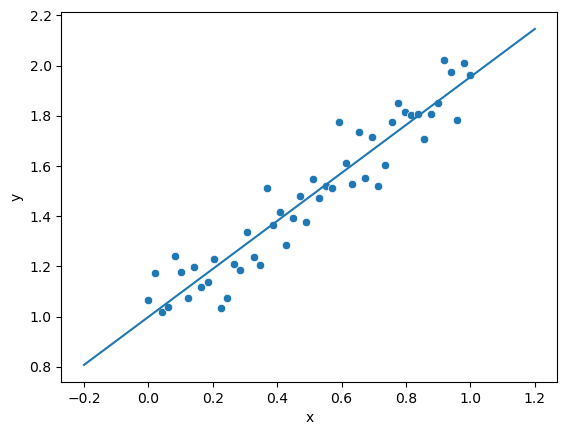

In [9]:
class Embedding(Module):
    def forward(self, x: np.ndarray) -> np.ndarray:
        # Add a bias term by appending 1 to each input
        return np.hstack([x, np.ones((x.shape[0], 1))])
    
    def backward(self, dy: np.ndarray) -> np.ndarray:
        # Ignore the gradient w.r.t. the appended 1 (constant term)
        return dy[:, :-1]



np.random.seed(42)
model = Sequential(
    Embedding(),
    # <- Add an embedding here?
    Linear(2, 1),  # A learnable linear map
)
problem = RegressionProblem(model, lambda x: x + 1)
problem.train(100)
problem.show()

### Does the embedding need a backward pass?

No, the embedding does not need a backward pass. It has a backward method, which slices the gradient to ignore the constant term. Since, appending a constant 1 does not affect the gradient, the embedding doesn't need a backward pass.

## Problem 3
> Now, let's solve a non-linear regression problem using a very simple neural network with a fixed (untrainable) hidden layer.
>
> Let $(r_i)_{i = 1}^d$ be a sequence of $d$ "reference inputs" and like $x$ be the input to the network. For each $i = 1, \dots, n,$ let the hidden neuron $h_i$ equal $1$ if $r_i$ is the reference input closest to $x$ and $0$ otherwise. Finally, let the output $y$ of the network be a linear combination
> $$
y = \sum_{i = 1}^n w_i h_i.
$$
>
> The following code implements such a network. **Analytically derive the optimal weights $w_i$ for this network under a squared error loss.** What is this network really learning? _(3 points)_

In [ ]:
class LocalEmbedding(Module):
    def __init__(self, references: np.ndarray):
        self.references = references  # (d_embed, d_in)
        self.d_embed, self.d_in = self.references.shape

    def forward(self, x):
        b = x.shape[0]
        out = np.zeros((b, self.d_embed))
        distances = np.sum((self.references[None] - x[:, None, :]) ** 2, axis=-1)
        out[np.arange(b), np.argmin(distances, axis=-1)] = 1
        return out

In [ ]:
np.random.seed(42)
model = Sequential(
    LocalEmbedding(np.linspace(0, 1, 8)[:, None]),
    Linear(8, 1),
)
problem = RegressionProblem(model, lambda x: np.sin(3 * x) + 1)
# problem.train(50)
problem.show()

## Problem 4
> Now we'll make the hidden neurons learnable. Each hidden neuron $h_i$ should compute $\sigma(a_i x + b_i),$ where $\sigma$ is the "logistic sigmoid function" $\sigma(x) = 1 / (1 + e^{-x})$  and $(a_i, b_i)$ are learnable parameters. As before, the output $y$ will be a learnable linear function of the hidden neurons $h_i.$
>
> **Implement and train this two-layer MLP on the same problem as above.** Use 16 hidden neurons. Find hyperparameters that make the network converge to a reasonable model in only 200 iterations. Graph the function learned by the network. _(5 points)_

In [ ]:
class Sigmoid(Module):
    def forward(self, x):
        self.x = x
        return 1 / (1 + np.exp(-x))

    def backward(self, dy):
        raise NotImplementedError()

In [ ]:
def make_simple_mlp(d_embed=16):
    return Sequential(
        # <- Something here?
        Linear(1, d_embed, init_scale=1, learning_rate=d_embed),
        # <- Something here?
        Linear(d_embed, 1, init_scale=1 / d_embed, learning_rate=1 / d_embed),
    )


np.random.seed(42)
problem = RegressionProblem(make_simple_mlp(), lambda x: np.sin(3 * x) + 1)
# problem.train(200)
problem.show()

## Problem 5
> The following class will train a model on a synthetic classification problem and display the learned classifier.

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm


def make_cluster(mean, n_points: int, label: int):
    return pd.DataFrame(
        {
            "x": mean[0] + 0.2 * randn(n_points),
            "y": mean[1] + 0.2 * randn(n_points),
            "label": label,
        }
    )


class ClassificationProblem:
    def __init__(self, model: Module):
        self.model = model
        self.n_clusters = 3
        self.df = pd.concat(
            [
                make_cluster([1, 1], 50, 0),
                make_cluster([-1, 1], 50, 1),
                make_cluster([-1, -1], 50, 0),
                make_cluster([1, -1], 50, 1),
                make_cluster([0, 0], 50, 2),
            ],
            axis=0,
        )

    def train(self, n_iters=100):
        loss = np.zeros(n_iters)
        for i in tqdm(range(n_iters)):
            self.model(self.df[["x", "y"]].to_numpy())
            self.model.backward(self.df["label"].to_numpy())
            loss[i] = self.model.components[-1].loss
            self.model.step()
        return loss

    def show(self, palette: str = "bright"):
        from matplotlib.colors import ListedColormap

        extent = (-2, 2, -2, 2)

        x, y = np.meshgrid(
            np.arange(*extent[:2], step=0.01),
            np.arange(*extent[2:], step=0.01),
        )
        colors = sns.color_palette(palette, n_colors=self.n_clusters)
        out = self.model(np.stack([arr.flatten() for arr in [x, y]], axis=1))
        plt.matshow(
            out.reshape(x.shape)[::-1, :],
            extent=extent,
            alpha=0.3,
            cmap=ListedColormap(colors),
        )
        sns.scatterplot(self.df, x="x", y="y", hue="label", palette=palette)

> **Build a two-layer MLP** and train it on this problem. Requirements:
>
> - Use the ReLU activation function for the hidden layer.
> - Use a softmax on the output layer to generate a vector of probabilities.
> - Train the network with cross-entropy loss.
>
> `ClassificationProblem.train()` expects that the backwards pass of your `Module` accepts a vector of true classes, and that its last layer computes a `loss` attribute. Feel free to edit this if you want. _(6 points)_

In [ ]:
@dataclass
class CrossEntropyLoss(Module):
    n_classes: int

    def forward(self, x):
        return np.argmax(x, axis=1)

    def backward(self, dy):
        # dy is a vector of true classes
        self.loss = NotImplementedError()
        raise NotImplementedError()


def make_classifier():
    # Replace these layers
    return Sequential(
        AffineEmbed(),
        Linear(3, 4),
        CrossEntropyLoss(n_classes=4),
    )


np.random.seed(42)
problem = ClassificationProblem(model=make_classifier())
# problem.train(100)
problem.show()

## Problem 6 (4 points)
> Build a neural network that can learn addition modulo 10. The architecture is up to you!
>
> Requirements:
>
> - _Do not_ encode numbers directly as input values. Instead, use one-hot embeddings or randomly initialized, learnable embeddings.
> - Reserve a very small fraction of data points to compute test loss.
> - Graph test loss and training loss over many epochs of full-batch gradient descent.
>
> For full points, test loss should drop to 0.

In [ ]:
def addition_dataset(n=10):
    values = np.arange(n)
    x, y = [arr.flatten() for arr in np.meshgrid(values, values)]
    return pd.DataFrame({"x": x, "y": y, "z": (x + y) % n})


sns.heatmap(addition_dataset().pivot(index="x", columns="y", values="z"))
plt.show()